<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [2]:
%matplotlib inline

# Setup environment and collect initial data

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="rgb_array")

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [4]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [5]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [6]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [7]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

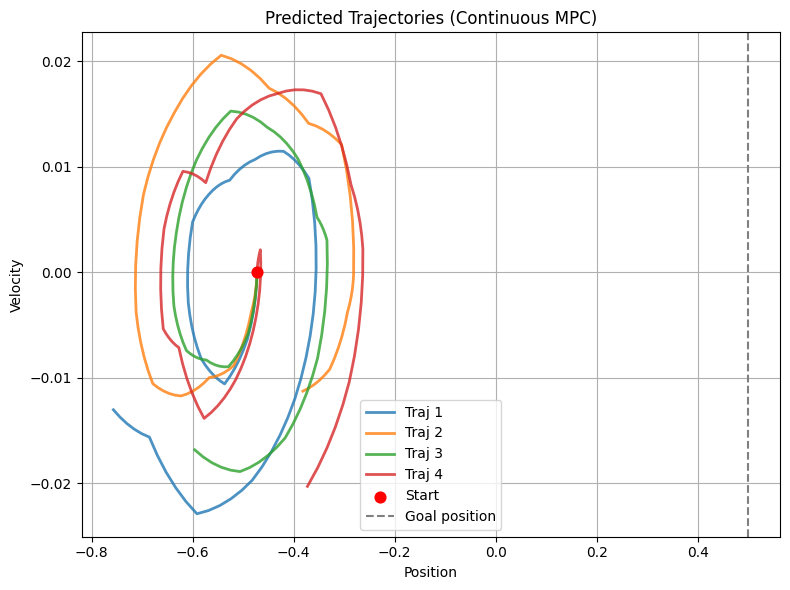

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5, rng=None):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################

    if rng is None:
        rng = np.random.default_rng()

    # 1. Sample action sequences
    # Use 'repeat' to promote smoother sequences (fewer switches).
    repeat = max(1, int(repeat))
    blocks = int(np.ceil(H / repeat))
    U_blocks = rng.uniform(-1.0, 1.0, size=(N_seq, blocks))
    U = np.repeat(U_blocks, repeats=repeat, axis=1)[:, :H]  # (N_seq, H)

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)  # J: shape (N_seq,)

    # 3. Select top trajectories
    plot_best = int(min(plot_best, N_seq))
    best_idx = np.argsort(J)[:plot_best]
    best_seq_idx = best_idx[0]              # index of the globally best sequence

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = float(U[best_seq_idx, 0])
    return np.clip(best_action, -1.0, 1.0)
    #return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [9]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.8561010471026236


/home/juan/anaconda3/envs/mujoco/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


t= 10 state= [-0.4801734   0.01166913] a= 0.9226752428396305
t= 20 state= [-0.33790734  0.01413414] a= 0.27290807578653564
t= 30 state= [-0.22829445  0.00624164] a= 0.9994329578214021
t= 40 state= [-0.29758146 -0.0197845 ] a= -0.8431368974298286
t= 50 state= [-0.6136543  -0.03738282] a= -0.1916462257220486
t= 60 state= [-0.9223828  -0.02456601] a= -0.6854701359543895
t= 70 state= [-1.01585     0.00398287] a= 0.06483257626979366
t= 80 state= [-0.79679805  0.03699088] a= 0.7391295361062975
t= 90 state= [-0.3269776   0.05038773] a= 0.5491628698473741
t= 100 state= [0.12866062 0.03977216] a= 0.7460563442512713
Episode return: 94.25


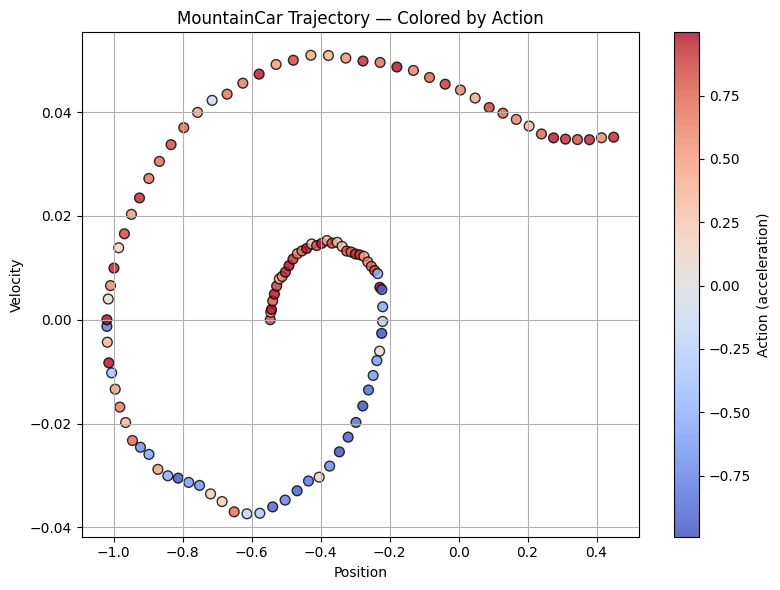

In [10]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

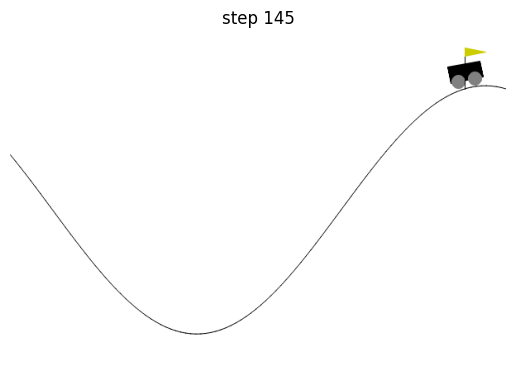

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")  # off-screen
obs, _ = env.reset(seed=0)

fig, ax = plt.subplots()
img = ax.imshow(env.render())      # first frame
ax.axis("off")
display(fig)

done, step = False, 0
while not done and step < 1000:
    a_scalar = mpc_action(obs, H=80, N_seq=100, plot=False)  # your function
    a = np.array([a_scalar], dtype=np.float32)  # <- your MPC action here
    obs, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    frame = env.render()            # returns HxWx3 RGB array
    img.set_data(frame)
    ax.set_title(f"step {step}")
    clear_output(wait=True); display(fig)
    plt.pause(0.001)
    step += 1

env.close()


**How does random shooting choose the best action?**

At the current state, we randomly sample many action sequences over a horizon 𝐻, simulate each sequence with the dynamic model to compute its total cost, and select the sequence with the lowest cost. We then apply only the first action of that best sequence and repeat this process at the next step (receding horizon MPC). Random shooting is popular because it’s simple, parallelizable, and works well with learned dynamics

**How do 𝐻 and 𝑁_seq affect the result?**

Larger 𝐻 lets the planner look further ahead (better long-term decisions), but increases computation and can make results more sensitive to model error. Too small 𝐻 can be myopic

More samples improve coverage of the action space and usually reduce cost, at the expense of runtime. In practice, performance monotonically improves with 𝑁 seq until diminishing returns.

**Did your car reach and stay near the goal?**

Once the car achieves the goal it goes beyond and does not maitain in the position. 

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

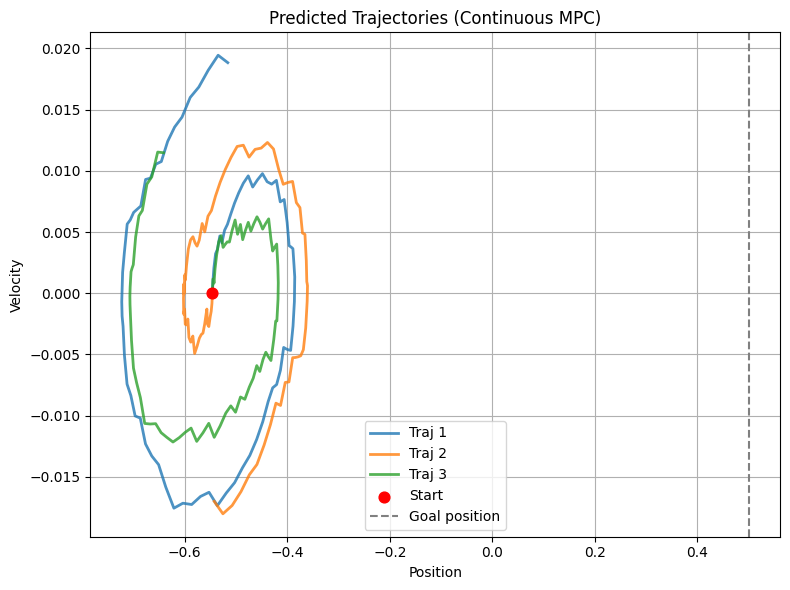

np.float64(0.7546874880783163)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def low_discrepancy_eps(n_seq, H, sigma):
    """Deterministic perturbations in [-sigma, sigma]."""
    try:
        from scipy.stats import qmc
        try:
            eng = qmc.Sobol(d=H, scramble=False)
        except Exception:
            eng = qmc.Halton(d=H, scramble=False)
        X = eng.random_base2(m=int(np.ceil(np.log2(max(1, n_seq)))))[:n_seq]   # [0,1]
        return ((2.0 * X - 1.0) * sigma).astype(np.float32)
    except Exception:
        k = np.arange(1, n_seq + 1, dtype=np.float32)[:, None]
        t = np.arange(H, dtype=np.float32)[None, :]
        return (sigma * np.cos(2.0 * np.pi * (k * (t + 1)) / (n_seq + 1))).astype(np.float32)


class MPPIController:
    def __init__(self, H=100, N_seq=200, lamda=1.0, sigma=0.3, u_min=-1.0, u_max=1.0):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.lamda = lamda      # Temperature parameter
        self.sigma = sigma

        self.u_min, self.u_max = float(u_min), float(u_max)

        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

        # RNG

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, sigma = self.H, self.N_seq, self.sigma

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        if H > 1:
            self.U_mean[:-1] = self.U_mean[1:]
            self.U_mean[-1]  = self.U_mean[-2]

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        dU = low_discrepancy_eps(N_seq, H, self.sigma)                 # (N, H)
        U  = np.clip(self.U_mean[None, :] + dU, self.u_min, self.u_max)

        # 2. Roll out trajectories
        all_traj, S = roll_out_n_trajectories(state, U)            # S shape (N,)

        # 3. Select the best trajectory (lowest cost)
        S_min = float(S.min())
        w = np.exp(-(S - S_min) / max(1e-8, self.lamda))             # (N,)
        w_sum = w.sum() + 1e-12
        self.U_mean = np.clip(self.U_mean + (w[:, None] * dU).sum(0) / w_sum, self.u_min, self.u_max)

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(S)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = self.U_mean[0]
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, lamda=1.0, sigma=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [13]:
# Initialize controller once
#mppi = MPPIController(H=30, N_seq=200, lamda=.10, sigma=.50)
mppi = MPPIController(H=20, N_seq=150, lamda=1.0, sigma=2.1)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -1.0
10 [-0.5692933  -0.01657371] -1.0
20 [-0.774754   -0.02075832] 1.0
30 [-0.7966593   0.01329765] 1.0
40 [-0.50323653  0.03966251] 1.0
50 [-0.07966431  0.04083996] 1.0
60 [0.27939597 0.0328759 ] 1.0
Total time: 65


<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipykernel_7731/1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


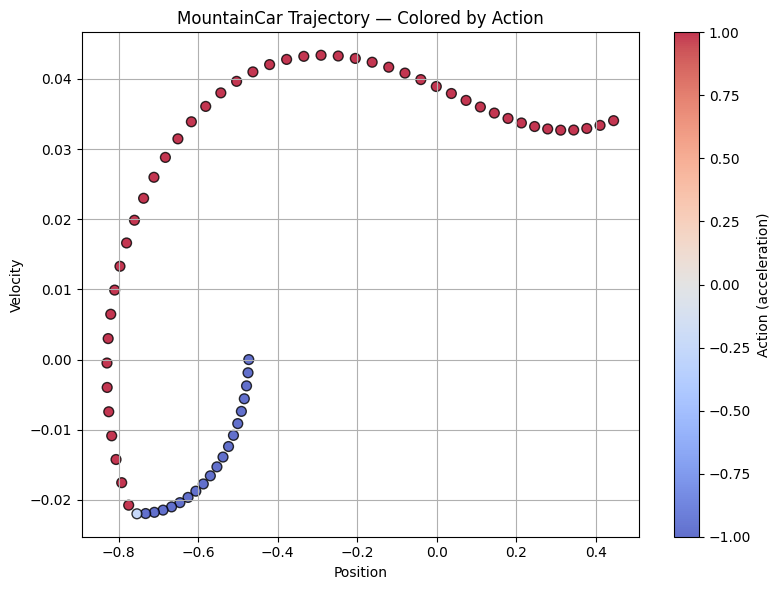

Energy 65.06022580390537


In [14]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

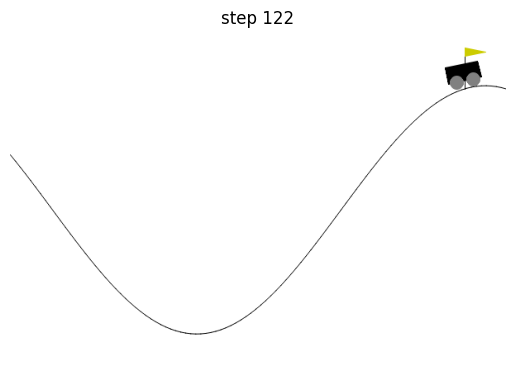

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")  # off-screen
obs, _ = env.reset(seed=0)

fig, ax = plt.subplots()
img = ax.imshow(env.render())      # first frame
ax.axis("off")
display(fig)

done, step = False, 0
while not done and step < 1000:
    mppi = MPPIController(H=20, N_seq=150, lamda=1.0, sigma=2.1)
    a_scalar = mppi.action(obs)
    #a_scalar = mpc_action(obs, H=80, N_seq=100, plot=False)  # your function
    a = np.array([a_scalar], dtype=np.float32)  # <- your MPC action here
    obs, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    frame = env.render()            # returns HxWx3 RGB array
    img.set_data(frame)
    ax.set_title(f"step {step}")
    clear_output(wait=True); display(fig)
    plt.pause(0.001)
    step += 1

env.close()


**Why does MPPI reuse the previous mean sequence (𝑈_mean)?**

Shifting 𝑈_mean forward gives a warm start that focuses sampling around a good plan from the previous timestep, improving sample efficiency and temporal consistency of actions in receding-horizon control.

**What would happen if we didn’t shift it each iteration?**

You’d re-optimize from scratch every step, so samples aren’t concentrated near previously good solutions. Expect noisier actions, more variability in costs, and typically worse real-time performance for the same sample budget. The warm-start/importance-sampling view explains the variance reduction you get by keeping and refining the mean

**How does the horizon 𝐻 affect stability and responsiveness?**

Larger 𝐻 looks further ahead, which can improve goal-directed planning (e.g., swing-up behaviors) but increases computation and can amplify model-error effects; too small 𝐻 is myopic and may react quickly but fail on long-horizon tasks. Choose 𝐻 to balance long-term optimality vs. responsiveness given your model fidelity and compute.

**Compare MPPI to random shooting — what advantage does MPPI bring?**

MPPI adds a principled, weighted update from path-integral control instead of pure “winner-take-all.” This yields better sample reuse, smoother plans, and allows tuning via the temperature (lamda). In practice, MPPI often achieves lower costs for the same number of rollouts and is amenable to GPU parallelization

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


# TASK A

In [ ]:
def cost_fn(state, a, x_star=0.45, w_pos=2000.0, w_vel=100.0, w_act=1.5):
#def cost_fn(state, a, x_star=0.45, w_pos=1.1, w_vel=1.1, w_act=1.1):
    x, v = state
    pos_err = x - x_star
    cost = w_pos*pos_err**2 \
            + w_vel*v**2 \
            + w_act*float(np.square(np.clip(a, -1.0, 1.0)))
    return cost

In [58]:
import gymnasium as gym
import numpy as np

class HoldAtSetpointWrapper(gym.Wrapper):
    """
    Keep episode running and require the car to *hold* near x*=0.45 with tiny velocity
    for a few steps before we consider it "done".
    """
    def __init__(self, env, x_star=0.45, pos_tol=0.01, v_tol=0.003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star)
        self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol)
        self.hold_steps_req = int(hold_steps)
        self._hold = 0
        # expose for controller/reporting
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))

    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)

    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])

        # override termination: we only "finish" after steady hold near setpoint
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        if near and slow:
            self._hold += 1
        else:
            self._hold = 0

        # never terminate early for reaching 0.45; require sustained hold
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)

        return s_next, r, terminated, truncated, info


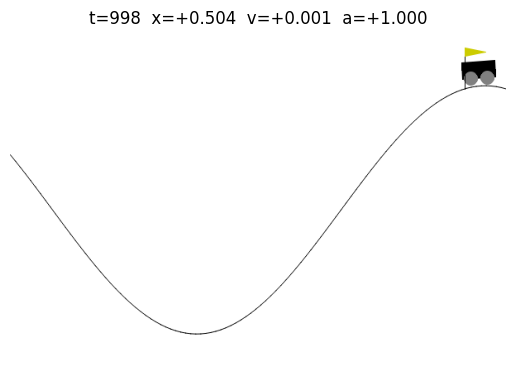

In [188]:
# make wrapped env for inline rendering
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=0.45, pos_tol=0.001, v_tol=0.003, hold_steps=12)

# your MPPI controller (weighted update version)
mppi = MPPIController(H=80, N_seq=256, lamda=1.0, sigma=0.6)

# control loop with inline render (same pattern you used earlier)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
obs, _ = env.reset(seed=0)

fig, ax = plt.subplots()
img = ax.imshow(env.render()); ax.axis("off"); display(fig)

done, t = False, 0
while not done and t < 2000:
    a_val = mppi.action(obs, plot=False)               # MPPI chooses u_0
    a = np.array([a_val], dtype=np.float32)
    obs, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    # live preview
    img.set_data(env.render())
    ax.set_title(f"t={t}  x={obs[0]:+.3f}  v={obs[1]:+.3f}  a={a_val:+.3f}")
    clear_output(wait=True); display(fig); 
    plt.pause(0.001)

    t += 1

env.close()


In [178]:
mppi = MPPIController(H=20, N_seq=150, lamda=1.0, sigma=2.1)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")

0 [-0.47260767  0.        ] 0.7546874880783163
10 [-0.4182856   0.00962809] 1.0
20 [-0.29519355  0.0132801 ] 1.0
30 [-0.17806724  0.00954112] 1.0
40 [-0.12277673  0.00195719] 1.0
50 [-0.14872803 -0.00622555] 1.0
60 [-0.24744327 -0.01226986] 1.0
70 [-0.37705132 -0.01235962] 1.0
80 [-0.46434197 -0.00477128] 1.0
90 [-0.45202565  0.00606567] 1.0
100 [-0.3484644   0.01279408] 1.0
110 [-0.22014996  0.0117468 ] 1.0
120 [-0.13570306  0.00523631] 1.0
130 [-0.12841938 -0.00300835] 1.0
140 [-0.20063287 -0.01031591] 1.0
150 [-0.3253681  -0.01327095] 1.0
160 [-0.43901196 -0.00860872] 1.0
170 [-0.47015855  0.00178699] 1.0
180 [-0.39772272  0.01095813] 1.0
190 [-0.26986122  0.01305392] 1.0
200 [-0.16152467  0.0082535 ] 1.0
210 [-0.12135544  0.00034804] 1.0
220 [-0.16285862 -0.00766254] 1.0
230 [-0.27203467 -0.01287191] 1.0
240 [-0.39960125 -0.01144495] 1.0
250 [-0.47053516 -0.00270472] 1.0
260 [-0.4376287   0.00788659] 1.0
270 [-0.32314923  0.01319397] 1.0
280 [-0.19886425  0.01078579] 1.0
290 [-0.12

<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipykernel_7731/1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


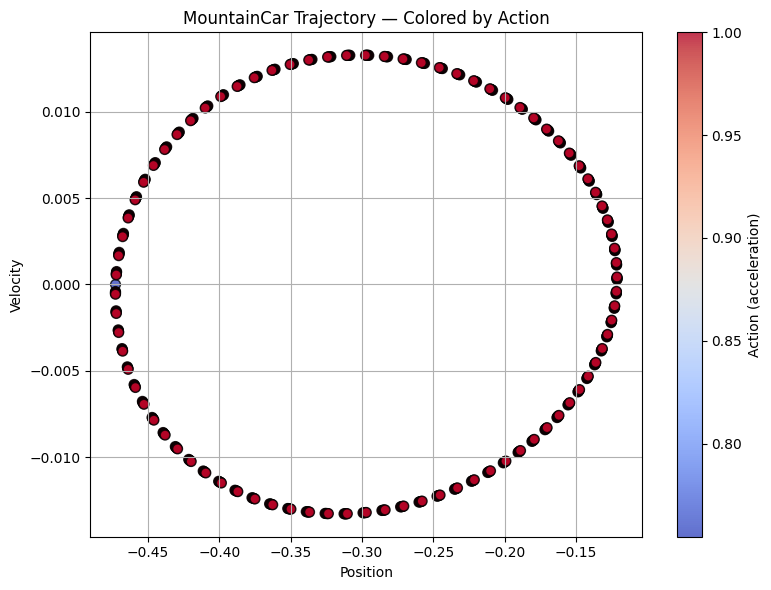

Energy 499.56955320466193


In [70]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

# TASK with GPU

# PART A from lab 7

In [71]:
# Part A — Collect data with a random policy (Gymnasium)
import numpy as np
import gymnasium as gym

def collect_random_data(env_name="MountainCarContinuous-v0", N=1000, seed=0, save_path=None):
    """
    Returns:
      X      : (N, S)    states x_t
      U      : (N, A)    actions u_t
      R      : (N,)      rewards r_t
      X_next : (N, S)    next states x_{t+1}
      dX     : (N, S)    state differences x_{t+1} - x_t
    """
    rng = np.random.default_rng(seed)
    env = gym.make(env_name)
    obs, _ = env.reset(seed=seed)

    S = env.observation_space.shape[0]
    A = env.action_space.shape[0]
    low, high = env.action_space.low, env.action_space.high

    X      = np.zeros((N, S), dtype=np.float32)
    U      = np.zeros((N, A), dtype=np.float32)
    R      = np.zeros((N,),   dtype=np.float32)
    X_next = np.zeros((N, S), dtype=np.float32)

    i = 0
    while i < N:
        # sample a random action uniformly over the valid bounds
        u = rng.uniform(low=low, high=high, size=A).astype(np.float32)

        obs_next, r, terminated, truncated, _ = env.step(u)

        X[i]      = obs
        U[i]      = u
        R[i]      = r
        X_next[i] = obs_next

        obs = obs_next
        done = terminated or truncated
        if done:
            obs, _ = env.reset()

        i += 1

    env.close()
    dX = X_next - X

    if save_path is not None:
        np.savez_compressed(save_path, X=X, U=U, R=R, X_next=X_next, dX=dX)
        print(f"Saved dataset to {save_path}")

    return X, U, R, X_next, dX

# Example run
if __name__ == "__main__":
    X, U, R, X_next, dX = collect_random_data(N=1000, seed=42, save_path="gp_mpc_random_data.npz")
    print("Shapes -> X:", X.shape, "U:", U.shape, "R:", R.shape, "X_next:", X_next.shape, "dX:", dX.shape)
    # quick sanity check: mean/var of dX
    print("dX mean:", dX.mean(axis=0), " | dX std:", dX.std(axis=0))


Saved dataset to gp_mpc_random_data.npz
Shapes -> X: (1000, 2) U: (1000, 1) R: (1000,) X_next: (1000, 2) dX: (1000, 2)
dX mean: [-3.2732653e-04  2.8187775e-05]  | dX std: [0.014118   0.00145227]


# PART B from lab 7

Loaded dataset from gp_mpc_random_data.npz  shapes -> X(1000, 2), U(1000, 1), dX(1000, 2)

=== Training GP for Δx[0] ===
iter  100  nll=-1.685
iter  200  nll=-3.401
iter  300  nll=-3.585
iter  400  nll=-3.617
iter  500  nll=-3.630
iter  600  nll=-3.632
iter  700  nll=-3.641
iter  800  nll=-3.642

=== Training GP for Δx[1] ===
iter  100  nll=-1.648
iter  200  nll=-3.326
iter  300  nll=-3.518
iter  400  nll=-3.556
iter  500  nll=-3.572
iter  600  nll=-3.582
iter  700  nll=-3.589
iter  800  nll=-3.593

RMSE per state-dimension on Δx (units of state): [8.3313298e-06 1.5132291e-06]


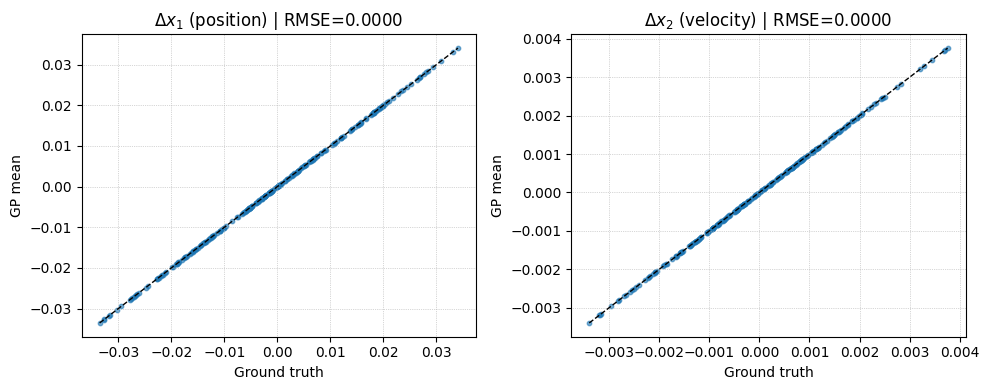

In [77]:
# Part B — Train a Gaussian Process model with GPyTorch
import os, numpy as np, torch, gpytorch, matplotlib.pyplot as plt

# ---------- A) Load (or create) data ----------
def load_or_make_data(path="gp_mpc_random_data.npz", N=1000, seed=42):
    try:
        D = np.load(path)
        X, U, dX = D["X"], D["U"], D["dX"]
        print(f"Loaded dataset from {path}  shapes -> X{X.shape}, U{U.shape}, dX{dX.shape}")
    except FileNotFoundError:
        import gymnasium as gym
        rng = np.random.default_rng(seed)
        env = gym.make("MountainCarContinuous-v0")
        obs, _ = env.reset(seed=seed)
        S, A = env.observation_space.shape[0], env.action_space.shape[0]
        low, high = env.action_space.low, env.action_space.high
        X = np.zeros((N, S), np.float32); U = np.zeros((N, A), np.float32); Xn = np.zeros_like(X)
        i = 0
        while i < N:
            u = rng.uniform(low=low, high=high, size=A).astype(np.float32)
            obs_next, _, term, trunc, _ = env.step(u)
            X[i] = obs; U[i] = u; Xn[i] = obs_next
            obs = obs_next
            if term or trunc: obs, _ = env.reset()
            i += 1
        env.close()
        dX = Xn - X
        np.savez_compressed(path, X=X, U=U, R=np.zeros(N), X_next=Xn, dX=dX)
        print(f"Generated and saved dataset to {path}")
    return X, U, dX

X, U, dX = load_or_make_data()
Z = np.concatenate([X, U], axis=1).astype(np.float32)   # inputs [pos, vel, action], shape (N,3)
Y = dX.astype(np.float32)                                # targets Δx, shape (N,2)

# ---------- B) Torch tensors & train/test split ----------
device = torch.device("cuda")
torch.manual_seed(0)
N = Z.shape[0]
perm = torch.randperm(N)
split = int(0.75 * N)
idx_tr, idx_te = perm[:split], perm[split:]

Zt = torch.from_numpy(Z).to(device)
Yt = torch.from_numpy(Y).to(device)

Z_tr, Z_te = Zt[idx_tr], Zt[idx_te]
Y_tr, Y_te = Yt[idx_tr], Yt[idx_te]

# ---------- C) Standardize (affine normalize) ----------
z_mean, z_std = Z_tr.mean(0), Z_tr.std(0).clamp_min(1e-6)
y_mean, y_std = Y_tr.mean(0), Y_tr.std(0).clamp_min(1e-6)

def z_norm(z): return (z - z_mean) / z_std
def y_norm(y): return (y - y_mean) / y_std
def y_unnorm(yn): return yn * y_std + y_mean

Z_tr_n, Z_te_n = z_norm(Z_tr), z_norm(Z_te)
Y_tr_n = y_norm(Y_tr)

# ---------- D) GP model (ExactGP) ----------
class AffineMean(gpytorch.means.Mean):
    """Linear + bias mean: m(z) = w^T z + b  (avoids ConstantMean()+LinearMean issue)"""
    def __init__(self, input_size):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.zeros(input_size)))
        self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.zeros(1)))
    def forward(self, x):
        return x.matmul(self.weights) + self.bias

class SingleOutputExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = AffineMean(train_x.shape[-1])
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1])
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp(train_x, train_y, iters=800, lr=0.05):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = SingleOutputExactGP(train_x, train_y, likelihood).to(device)
    model.train(); likelihood.train()
    opt = torch.optim.Adam([{'params': model.parameters()}], lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(iters):
        opt.zero_grad(set_to_none=True)
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        opt.step()
        if (i+1) % 100 == 0:
            print(f"iter {i+1:4d}  nll={loss.item():.3f}")
    return model, likelihood

# Train two independent GPs: one for Δpos, one for Δvel
gp_models = []
for j in range(Y.shape[1]):
    print(f"\n=== Training GP for Δx[{j}] ===")
    yj = Y_tr_n[:, j]
    m, lk = fit_gp(Z_tr_n, yj, iters=800, lr=0.05)
    gp_models.append((m.eval(), lk.eval()))

# ---------- E) Predict on test and compute RMSE ----------
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_s = []
    for (m, lk) in gp_models:
        dist = m(Z_te_n)
        mean = lk(dist).mean  # mean of predictive (same as dist.mean for GaussianLikelihood)
        preds_s.append(mean)
    Y_pred_n = torch.stack(preds_s, dim=1)
    Y_pred = y_unnorm(Y_pred_n)

rmse = torch.sqrt(torch.mean((Y_pred - Y_te)**2, dim=0))
print(f"\nRMSE per state-dimension on Δx (units of state): {rmse.cpu().numpy()}")

# ---------- F) Parity plots ----------
Y_te_np = Y_te.detach().cpu().numpy()
Y_pr_np = Y_pred.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = [r"$\Delta x_1$ (position)", r"$\Delta x_2$ (velocity)"]
for j, ax in enumerate(axes):
    ax.scatter(Y_te_np[:, j], Y_pr_np[:, j], s=10, alpha=0.6)
    lo = float(min(Y_te_np[:, j].min(), Y_pr_np[:, j].min()))
    hi = float(max(Y_te_np[:, j].max(), Y_pr_np[:, j].max()))
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1)
    ax.set_xlabel("Ground truth")
    ax.set_ylabel("GP mean")
    ax.set_title(f"{labels[j]} | RMSE={rmse[j].item():.4f}")
    ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- G) Convenience: callable GP dynamics (mean prediction) ----------
def gp_dynamics_predict(x, u):
    """
    x: (...,2) state [pos, vel]
    u: (...,1) action
    returns mean Δx (...,2) as torch tensor on current device
    """
    z = torch.cat([torch.as_tensor(x, dtype=torch.float32, device=device).reshape(-1, 2),
                   torch.as_tensor(u, dtype=torch.float32, device=device).reshape(-1, 1)], dim=1)
    z_n = (z - z_mean) / z_std
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        outs = []
        for (m, lk) in gp_models:
            outs.append(lk(m(z_n)).mean)
        dx_n = torch.stack(outs, dim=1)
    return dx_n * y_std + y_mean  # unnormalize


# PART C from lab 7

In [183]:
# ===== Window 1: Setup + gp_dynamics_predict sanity checks =====
import torch, numpy as np

# 1) Device: prefer CUDA, but fall back safely if not available
device = torch.device("cuda")
print("Device:", device)

# 2) MountainCarContinuous goal (termination position)
GOAL_POS = 0.45

# 3) Make sure Part B was run and gp_dynamics_predict exists
assert 'gp_dynamics_predict' in globals(), "Run your Part B cell first so gp_dynamics_predict is defined."

# 4) Batch/device/dtype check for gp_dynamics_predict
K = 2048  # batch size 
x = torch.zeros(K, 2, device=device, dtype=torch.float32)   # [pos, vel]
u = torch.zeros(K, 1, device=device, dtype=torch.float32)   # action

with torch.no_grad():
    dx = gp_dynamics_predict(x, u)

# 5) Validate shape, device, dtype
assert isinstance(dx, torch.Tensor), "gp_dynamics_predict must return a torch.Tensor"
assert dx.shape == (K, 2), f"Expected (K,2) = ({K},2) but got {tuple(dx.shape)}"
assert dx.device.type == device.type, f"gp_dynamics_predict returned on {dx.device}, expected {device}"
assert dx.dtype == torch.float32, f"gp_dynamics_predict returned {dx.dtype}, expected torch.float32"

print("[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.")


Device: cuda
[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.


# MPPI with GPU

In [184]:
# ===== Window 2: MPPI (no rendering) =====
import torch

# Uses `device` and `GOAL_POS` from Window 1
assert 'device' in globals() and 'GOAL_POS' in globals()
assert 'gp_dynamics_predict' in globals(), "gp_dynamics_predict must be defined (from Part B)."

def mc_reward_vec(x_next, u):
    # x_next: (K,2)  u: (K,1)
    r = (x_next[:, 0] >= GOAL_POS).float() * 100.0   # terminal bonus at goal
    r = r - 0.1 * (u[:, 0] ** 2)                     # action penalty
    r = r + 3.0 * x_next[:, 0]                       # position shaping
    r = r + 1.5 * torch.clamp(x_next[:, 1], min=0.0) # small bonus for rightward speed
    return r

class MPPI:
    """
    Fully-batched MPPI with AR(1) time-correlated noise.
    Keep everything float32 on `device`. Assumes gp_dynamics_predict(x,u) -> Δx (K,2).
    """
    def __init__(self, act_low, act_high, H=32, K=1536, sigma=0.45, lam=1.0, seed=0, rho=0.8):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.rho = float(sigma), float(lam), float(rho)
        self.act_low  = torch.as_tensor([[act_low]],  device=device, dtype=torch.float32)
        self.act_high = torch.as_tensor([[act_high]], device=device, dtype=torch.float32)
        self.U_bar = torch.zeros(self.H, 1, device=device, dtype=torch.float32)
        g = torch.Generator(device=device); g.manual_seed(int(seed))
        self.rng = g

    @torch.no_grad()
    def _sample_noise(self):
        K, H = self.K, self.H
        eps = torch.zeros(K, H, 1, device=device, dtype=torch.float32)
        z   = torch.randn(K, H, 1, device=device, generator=self.rng, dtype=torch.float32)
        eps[:, 0, :] = self.sigma * z[:, 0, :]
        if H > 1:
            step_std = self.sigma * (1.0 - self.rho**2) ** 0.5
            for t in range(1, H):
                eps[:, t, :] = self.rho * eps[:, t-1, :] + step_std * z[:, t, :]
        return eps  # (K,H,1)

    @torch.no_grad()
    def plan(self, x0):
        # x0: (2,) array-like
        x0 = torch.as_tensor(x0, dtype=torch.float32, device=device).reshape(2)
        U  = torch.clamp(self.U_bar.unsqueeze(0) + self._sample_noise(), self.act_low, self.act_high)  # (K,H,1)

        x     = x0.expand(self.K, -1).clone()                          # (K,2)
        done  = torch.zeros(self.K, dtype=torch.bool, device=device)
        costs = torch.zeros(self.K, device=device, dtype=torch.float32)

        for t in range(self.H):
            u_t = U[:, t, :]                                           # (K,1)
            dx  = gp_dynamics_predict(x, u_t)                          # (K,2)
            x   = x + dx
            r   = mc_reward_vec(x, u_t)                                # (K,)
            costs -= torch.where(done, torch.zeros_like(r), r)
            done |= (x[:, 0] >= GOAL_POS)

        # MPPI importance weights
        cmin = costs.min()
        w = torch.exp(-(costs - cmin) / self.lam)                      # (K,)
        Z = torch.clamp(w.sum(), min=1e-12)

        # Update mean sequence and warm-start (shift)
        self.U_bar = (w.view(self.K, 1, 1) * U).sum(dim=0) / Z          # (H,1)
        self.U_bar = torch.clamp(self.U_bar, self.act_low, self.act_high)
        a0 = self.U_bar[0].clone()
        self.U_bar = torch.roll(self.U_bar, shifts=-1, dims=0); self.U_bar[-1] = 0.0
        return a0


In [81]:
# ===== Window 3: Tuned MPPI with ORACLE dynamics to validate the planner =====
import time, numpy as np, torch, gymnasium as gym

assert 'MPPI' in globals(), "Run Window 2 so MPPI is defined."
assert 'device' in globals() and 'GOAL_POS' in globals()

# --- True MountainCarContinuous dynamics: returns Δx (batch) ---
def true_dynamics_dx(x, u):
    # x: (K,2) [pos, vel], u: (K,1) in [-1,1]
    pos, vel = x[:, 0], x[:, 1]
    force = torch.clamp(u[:, 0], -1.0, 1.0)
    vel_next = vel + force * 0.0015 - 0.0025 * torch.cos(3.0 * pos)
    pos_next = pos + vel_next
    return torch.stack([pos_next - pos, vel_next - vel], dim=1)

# --- Swap to oracle dynamics just for this test ---
_gp_backup = gp_dynamics_predict
gp_dynamics_predict = true_dynamics_dx

def run_oracle_tuned(H=100, K=100, sigma=0.6, lam=50.0, rho=0.95, seed=7, max_steps=5500):
    env = gym.make("MountainCarContinuous-v0", render_mode="human")  # headless
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]

    mppi = MPPI(low, high, H=H, K=K, sigma=sigma, lam=lam, seed=seed, rho=rho)

    # Prime the sequence with a decisive left shove so MPPI can refine the swing
    warm_left = min(10, H)  # up to 60 steps of reverse
    mppi.U_bar[:warm_left] = -0.1

    total_return, success_step, plan_times = 0.0, None, []
    for t in range(max_steps):
        t0 = time.perf_counter()
        a = mppi.plan(obs).detach().cpu().numpy()
        if torch.cuda.is_available(): torch.cuda.synchronize()
        plan_times.append(time.perf_counter() - t0)

        obs, r, terminated, truncated, _ = env.step(a)
        total_return += r
        if obs[0] >= GOAL_POS and success_step is None:
            success_step = t + 1
        if terminated or truncated:
            break
    env.close()
    return {
        "return": float(total_return),
        "success": bool(success_step is not None),
        "success_step": int(success_step) if success_step is not None else None,
        "plan_ms_median": float(np.median(plan_times) * 1000.0),
        "H": H, "K": K, "sigma": sigma, "lam": lam, "rho": rho
    }

oracle_stats = run_oracle_tuned()
print("Oracle (tuned) :", oracle_stats)

# --- Restore your GP predictor after the oracle test ---
gp_dynamics_predict = _gp_backup


Oracle (tuned) : {'return': 93.83325497717713, 'success': True, 'success_step': 99, 'plan_ms_median': 12.161378999735462, 'H': 100, 'K': 100, 'sigma': 0.6, 'lam': 50.0, 'rho': 0.95}


In [83]:
# ---------- Part D: Evaluate & Visualize (tuned MPPI) ----------
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch

assert 'MPPI' in globals(), "Define MPPI first (Window 2)."
assert 'gp_dynamics_predict' in globals(), "Run Part B first."
assert 'GOAL_POS' in globals()

#H=100, K=100, sigma=0.6, lam=50.0, rho=0.95, seed=7, max_steps=5500

# ---- Helpers ----
def run_mppi_trajectory(H=100, K=100, sigma=0.6, lam=50.0, rho=0.95,
                        max_steps=500, seed=0, render_mode=None, warm_left=1):
    """Run one MPPI episode and record trajectory."""
    env = gym.make("MountainCarContinuous-v0", render_mode=render_mode)
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]

    mppi = MPPI(low, high, H=H, K=K, sigma=sigma, lam=lam, seed=seed, rho=rho)
    # strong left shove to help discover the swing; MPPI will refine it
    mppi.U_bar[:min(warm_left, H)] = -0.95

    traj = {"pos": [], "vel": [], "act": [], "rew": []}
    total_return = 0.0
    for t in range(max_steps):
        a = mppi.plan(obs).detach().cpu().numpy()
        obs, r, terminated, truncated, _ = env.step(a)
        traj["pos"].append(obs[0]); traj["vel"].append(obs[1])
        traj["act"].append(float(a[0])); traj["rew"].append(r)
        total_return += r
        if terminated or truncated:
            break
    env.close()
    return (np.array(traj["pos"]), np.array(traj["vel"]),
            np.array(traj["act"]), np.array(traj["rew"]), float(total_return))

def run_random_trajectory(max_steps=999, seed=1, render_mode=None):
    """Random baseline."""
    env = gym.make("MountainCarContinuous-v0", render_mode=render_mode)
    obs, _ = env.reset(seed=seed)
    low, high = env.action_space.low[0], env.action_space.high[0]
    rng = np.random.default_rng(seed)

    traj = {"pos": [], "vel": [], "act": [], "rew": []}
    total_return = 0.0
    for t in range(max_steps):
        a = rng.uniform(low, high, size=(1,)).astype(np.float32)
        obs, r, terminated, truncated, _ = env.step(a)
        traj["pos"].append(obs[0]); traj["vel"].append(obs[1])
        traj["act"].append(float(a[0])); traj["rew"].append(r)
        total_return += r
        if terminated or truncated:
            break
    env.close()
    return (np.array(traj["pos"]), np.array(traj["vel"]),
            np.array(traj["act"]), np.array(traj["rew"]), float(total_return))

# ---- Run and plot ----
pos_mppi, vel_mppi, act_mppi, rew_mppi, ret_mppi = run_mppi_trajectory(
    H=120, K=1024, sigma=0.6, lam=50.0, rho=0.95, seed=0, render_mode="human"
)



# MPPI GPU OPTIMAL SAVING ENERGY

In [185]:
# ===== Window 1: Setup + gp_dynamics_predict sanity checks =====
import torch, numpy as np

# 1) Device: prefer CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 2) MountainCarContinuous goal (termination position in the official env)
GOAL_POS = 0.45  # Gymnasium docs
# 3) Ensure your learned GP model predictor exists: gp_dynamics_predict(x,u)->Δx (torch, batched)
assert 'gp_dynamics_predict' in globals(), "Run your Part B cell first so gp_dynamics_predict is defined."

# 4) Batch/device/dtype check for gp_dynamics_predict
K = 2048  # batch size
x = torch.zeros(K, 2, device=device, dtype=torch.float32)   # [pos, vel]
u = torch.zeros(K, 1, device=device, dtype=torch.float32)   # action

with torch.no_grad():
    dx = gp_dynamics_predict(x, u)

# 5) Validate shape, device, dtype
assert isinstance(dx, torch.Tensor), "gp_dynamics_predict must return a torch.Tensor"
assert dx.shape == (K, 2), f"Expected (K,2) but got {tuple(dx.shape)}"
assert dx.device.type == device.type, f"Returned {dx.device}, expected {device}"
assert dx.dtype == torch.float32, f"Returned {dx.dtype}, expected torch.float32"

print("[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.")


Device: cuda
[check] gp_dynamics_predict passes (shape/device/dtype). Proceed to Window 2.


In [ ]:
import torch
GOAL_POS = 0.45

def cost_fn_torch(x_next: torch.Tensor, u: torch.Tensor,
                  x_star: float = GOAL_POS,
                  w_pos: float = 2000.0, w_vel: float = 200.0, w_act: float = 1.5):
    # x_next: (K,2); u: (K,1)
    x = x_next[:, 0]
    v = x_next[:, 1]
    uu = u[:, 0].clamp(-1.0, 1.0)
    pos_err = x - x_star
    return w_pos*(pos_err**2) + w_vel*(v**2) + w_act*(uu**2)


In [217]:
# === Window 2: Minimal GPU MPPI using gp_dynamics_predict (Δx) ===
assert 'gp_dynamics_predict' in globals(), "Define gp_dynamics_predict(x,u)->Δx (torch)."

class MPPI_GPU:
    """
    Vanilla MPPI on GPU:
      - Correlated (AR(1)) Gaussian noise around a mean sequence Ū
      - Rollouts via gp_dynamics_predict(x,u) -> Δx (K,2)
      - IT-MPPI weights: w = exp(-(S - S_min)/λ)
      - Update Ū by weighted average of candidates
    """
    def __init__(self, act_low, act_high, H=80, K=1024, sigma=0.6, lam=25.0, rho=0.9, seed=0):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.rho = float(sigma), float(lam), float(rho)
        self.low  = torch.tensor([[act_low]],  device=device, dtype=torch.float32)
        self.high = torch.tensor([[act_high]], device=device, dtype=torch.float32)
        self.U_bar = torch.zeros(self.H, 1, device=device, dtype=torch.float32)
        g = torch.Generator(device=device); g.manual_seed(int(seed))
        self.rng = g

    @torch.no_grad()
    def _sample_eps(self):
        # AR(1) noise in (K,H,1)
        K, H = self.K, self.H
        z = torch.randn(K, H, 1, device=device, generator=self.rng, dtype=torch.float32)
        eps = torch.zeros_like(z)
        eps[:, 0, :] = self.sigma * z[:, 0, :]
        if H > 1:
            step_std = self.sigma * (1.0 - self.rho**2) ** 0.5
            for t in range(1, H):
                eps[:, t, :] = self.rho * eps[:, t-1, :] + step_std * z[:, t, :]
        return eps

    @torch.no_grad()
    def action(self, obs_np):
        # 0) warm start (shift) — safe
        if self.H > 1:
            self.U_bar = torch.roll(self.U_bar, shifts=-1, dims=0)
            self.U_bar[-1] = 0.0

        # 1) candidates
        eps = self._sample_eps()                                        # (K,H,1)
        U   = (self.U_bar.unsqueeze(0) + eps).clamp(self.low, self.high)# (K,H,1)

        # optional tiny smoothing to create longer pushes (helps momentum)
        if self.H > 2:
            U[:, 1:-1, 0] = (U[:, :-2, 0] + U[:, 1:-1, 0] + U[:, 2:, 0]) / 3.0

        # 2) rollouts & stage costs
        x = torch.as_tensor(obs_np, device=device, dtype=torch.float32).reshape(1,2).repeat(self.K,1)
        S = torch.zeros(self.K, device=device, dtype=torch.float32)

        for t in range(self.H):
            u_t = U[:, t, :]                  # (K,1)
            dx  = gp_dynamics_predict(x, u_t) # (K,2)  Δx (your GP)
            x   = x + dx
            S  += cost_fn_torch(x, u_t)       # set-point stage cost

        # 2b) terminal quadratic (park at x*=0.45, v*=0)
        x_star = torch.tensor([GOAL_POS, 0.0], device=x.device, dtype=x.dtype)
        S += 1.5e4 * (x[:,0]-x_star[0])**2 + 2.0e3 * (x[:,1]-x_star[1])**2

        # 3) IT-MPPI weights + update
        Smin = S.min()
        w = torch.exp(-(S - Smin) / self.lam).clamp_min(1e-12)          # (K,)
        Z = w.sum().clamp_min(1e-12)
        self.U_bar = ((w.view(self.K,1,1) * U).sum(dim=0) / Z).clamp(self.low, self.high)

        # 4) receding-horizon action
        return float(self.U_bar[0].item())



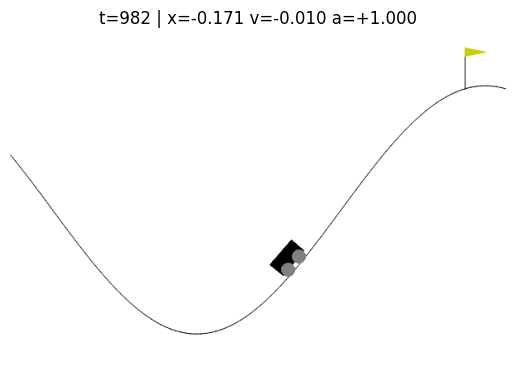

KeyboardInterrupt: 

In [218]:
# === Window 3: Wrap env to keep running & hold at x*=0.45 ===
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

class HoldAtSetpointWrapper(gym.Wrapper):
    def __init__(self, env, x_star=0.45, pos_tol=0.01, v_tol=0.003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star); self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol);   self.hold_steps_req = int(hold_steps)
        self._hold = 0
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))
    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)
    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        self._hold = self._hold + 1 if (near and slow) else 0
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)
        return s_next, r, terminated, truncated, info

# --- make env + controller ---
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=0.45, pos_tol=0.008, v_tol=0.003, hold_steps=12)

obs, _ = env.reset(seed=0)
low, high = env.action_space.low[0], env.action_space.high[0]
mppi = MPPI_GPU(low, high, H=120, K=1024, sigma=0.7, lam=30.0, rho=0.98, seed=0)

# seed Ū with a brief left push to build momentum
mppi.U_bar[:12] = -0.95

# --- inline render loop (same style you used) ---
fig, ax = plt.subplots()
img = ax.imshow(env.render()); ax.axis("off"); display(fig)

done, t, TMAX = False, 0, 2000
while not done and t < TMAX:
    a_val = mppi.action(obs)
    a = np.array([a_val], dtype=np.float32)
    obs, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    img.set_data(env.render())
    ax.set_title(f"t={t} | x={obs[0]:+.3f} v={obs[1]:+.3f} a={a_val:+.3f}")
    clear_output(wait=True); display(fig); plt.pause(0.001)
    t += 1

env.close()
